In [1]:
from deeplab3.dataloaders import make_data_loader
from deeplab3.dataloaders import custom_transforms as tr
from deeplab3.dataloaders.utils import decode_segmap
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import torch

import pickle
import datetime

import model_utils

Visualize Darkening Effect
----

In [2]:
from deeplab3.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file('../configs/coco_rgbd.yaml')
cfg.merge_from_list(['DATASET.ROOT', '../datasets/coco/'])

In [3]:
dataloaders = make_data_loader(cfg)

loading annotations into memory...
Done (t=54.81s)
creating index...
index created!
Using RGB-D input
loading annotations into memory...
Done (t=1.71s)
creating index...
index created!
Using RGB-D input


Text(0.5, 1.0, 'Original')

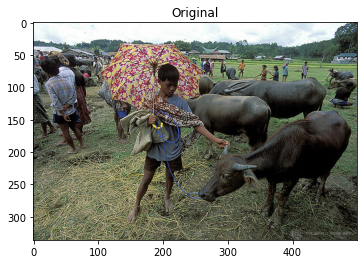

In [4]:
dataset = dataloaders[0].dataset
img_path, depth_path, label_path = dataset.coco_paths(2)
sample = dataset.loader.get_sample(img_path, depth_path, label_path)
image = sample['image']

plt.figure()
plt.imshow(image)
plt.title("Original")

### Different Darkening Degrees

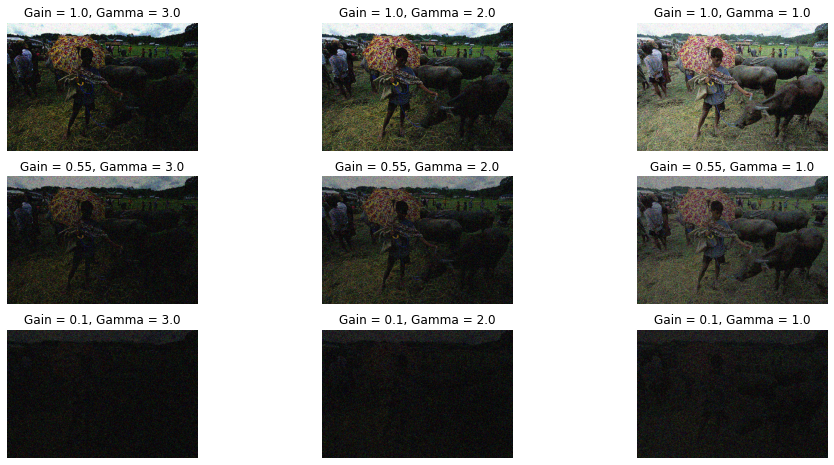

In [89]:
gain = np.linspace(0.1, 1, 3).tolist()
gain.reverse()
gamma = np.linspace(1,3, 3).tolist()
gamma.reverse()

plt.figure(figsize=(16, 8))

index = 1
for i in gain:
    for j in gamma:
        sample['image'] = image.copy()
        
        cfg = get_cfg_defaults()
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        f = tr.Darken(cfg)
        processed_sample = f(sample)
        
        plt.subplot(len(gain), len(gamma), index)
        plt.imshow(processed_sample['image'])
        plt.title("Gain = {}, Gamma = {}".format(i, j))
        plt.axis('off')
        
        index += 1

### RE-Brightened to visualize noise

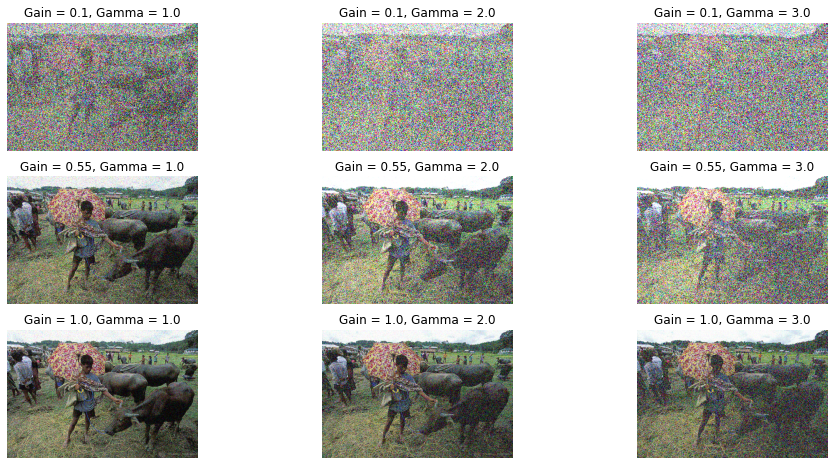

In [6]:
plt.figure(figsize=(16, 8))

index = 1
for i in gain:
    for j in gamma:
        sample['image'] = image.copy()
        
        cfg = get_cfg_defaults()
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        f = tr.Darken(cfg)
        processed_sample = f(sample)
        
        f = tr.UnDarken(cfg)
        processed_sample = f(processed_sample)
        
        plt.subplot(len(gain), len(gamma), index)
        plt.imshow(processed_sample['image'])
        plt.title("Gain = {}, Gamma = {}".format(i, j))
        plt.axis('off')
        index += 1

## Network Performance

In [7]:
model_configs = model_utils.get_all_models("../run/")
len(model_configs)

100

In [64]:
low_light_models = ['../run/older/cityscapes_rgbd_xception_fine/2020_04_26-20_04_07/parameters.txt.yaml',
                   '../run/older/cityscapes_rgb_xception_pt/2020_04_27-01_43_58/parameters.txt.yaml',
                   '../run/cityscapes/cityscapes_rgbd_xception_low_light/2020_09_25-19_32_43/parameters.yaml',
                   '../run/cityscapes/cityscapes_rgb_xception_low_light/2020_09_25-19_36_53/parameters.yaml',
                   '../run/scenenet/scenenet_rgbd_xception/2020_09_17-22_10_19/parameters.yaml',
                   '../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/parameters.yaml',
                   '../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_25-23_11_51/parameters.yaml',
                   '../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_28-08_36_05/parameters.yaml']

In [ ]:
failed = []

metric_dict = {'RGB': { 'low-light': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}},
                        'normal': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}}} ,
               'RGBD' : { 'low-light': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}},
                        'normal': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}}}}

for cfg_filepath in low_light_models:
    try:
        cfg = model_utils.match_cfg_versions(cfg_filepath)
        cfg.merge_from_list(['CHECKPOINT.DIRECTORY', os.path.dirname(cfg_filepath),
                             'TEST.MAX_ITER', 1000,
                             'MODEL.PRETRAINED', "",
                             'SYSTEM.GPU_IDS', [0]]) #Since we're using saved models, pretrained weights will be overwritten anyway.

        for i in gain:
            for j in gamma:
                low = "low-light" if cfg.DATASET.DARKEN.DARKEN else "normal"
#                 model_output[i][j][cfg.DATASET.NAME][cfg.DATASET.MODE] = {'dataset': cfg.DATASET.NAME,
#                                                  'model': cfg.MODEL.NAME,
#                                                  'image_type': cfg.DATASET.MODE,
#                                                  'low-light': cfg.DATASET.DARKEN.DARKEN,
#                                                  'epoch': checkpoint['epoch']}
                
                cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                                    'DATASET.DARKEN.GAIN', float(i),
                                    'DATASET.DARKEN.GAMMA', float(j)])
        
                model_filepath = os.path.join(cfg.CHECKPOINT.DIRECTORY, cfg.CHECKPOINT.MODEL)
                checkpoint = torch.load(model_filepath, map_location=torch.device('cpu'))
                
                result_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, 'validation_report_gain{:3.2f}_gamma{:3.2f}.txt'.format(float(i), float(j)))
                print(result_file)
                checkpoint_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, 'checkpoint.pth.tar')
                if os.path.exists(result_file) and (os.path.getmtime(result_file) > os.path.getmtime(checkpoint_file)):
                    with open(result_file, 'r') as fp:
                        metric_str = fp.read().split('{')[1].split('}')[0].replace("'", '"')
                        metrics = json.loads('{' + metric_str + '}')
                else:
                    metrics = model_utils.test_model(cfg, result_file)

                metric_dict[cfg.DATASET.MODE][low][cfg.DATASET.NAME][i][j] = metrics['mIoU']
        
    except Exception as e:
        print(e)
        print(cfg_filepath)
        failed.append(cfg_filepath)
        

Non-existent key: TRAIN.LR_SCHEDULER
Non-existent key: TRAIN.MOMENTUM
Non-existent key: TRAIN.NESTROV
Non-existent key: TRAIN.WEIGHT_DECAY
../run/older/cityscapes_rgbd_xception_fine/2020_04_26-20_04_07/validation_report_gain1.00_gamma3.00.txt
Using RGB-D input
Found 2975 train images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 1525 test images
Training backbone from scratch


:   0%|          | 0/63 [00:00<?, ?it/s]

=> loaded checkpoint '../run/older/cityscapes_rgbd_xception_fine/2020_04_26-20_04_07/checkpoint.pth.tar' (epoch 185)


Test loss: 0.830: 100%|██████████| 63/63 [03:42<00:00,  3.53s/it]


expected str, bytes or os.PathLike object, not NoneType
../run/older/cityscapes_rgbd_xception_fine/2020_04_26-20_04_07/parameters.txt.yaml
Non-existent key: TRAIN.LR_SCHEDULER
Non-existent key: TRAIN.MOMENTUM
Non-existent key: TRAIN.NESTROV
Non-existent key: TRAIN.WEIGHT_DECAY
../run/older/cityscapes_rgb_xception_pt/2020_04_27-01_43_58/validation_report_gain1.00_gamma3.00.txt
Using RGB input
Found 19997 train_extra images
Using RGB input
Found 500 val images
Using RGB input
Found 1525 test images
Loading pretrained Xception model: http://data.lip6.fr/cadene/pretrainedmodels/xception-b5690688.pth


:   0%|          | 0/63 [00:00<?, ?it/s]

=> loaded checkpoint '../run/older/cityscapes_rgb_xception_pt/2020_04_27-01_43_58/checkpoint.pth.tar' (epoch 101)


Test loss: 0.726:  29%|██▊       | 18/63 [00:52<02:08,  2.86s/it]

In [80]:
print(len(failed))
print(metrics)
metric_dict

0
{'Acc': 0.7425602954740125, 'Acc_class': 0.438370537617509, 'mIoU': 0.3295845740600201, 'FWIoU': 0.6031186934892203}


{'RGB': {'low-light': {'scenenet': {0.1: {1.0: 0.16103989993868392,
     2.0: 0.15516987459179982,
     3.0: 0.1355720685315653},
    0.55: {1.0: 0.3295845740600201,
     2.0: 0.3295845740600201,
     3.0: 0.3295845740600201},
    1.0: {1.0: 0.3295845740600201,
     2.0: 0.3295845740600201,
     3.0: 0.3295845740600201}},
   'cityscapes': {0.1: {1.0: 0.20154699736544535,
     2.0: 0.169067801961672,
     3.0: 0.12839737952348437},
    0.55: {1.0: 0.41487383928810123,
     2.0: 0.3690895555339986,
     3.0: 0.3690895555339986},
    1.0: {1.0: 0.3690895555339986,
     2.0: 0.3690895555339986,
     3.0: 0.3690895555339986}}},
  'normal': {'scenenet': {0.1: {1.0: 0.00679641015466752, 2.0: 0, 3.0: 0},
    0.55: {1.0: 0, 2.0: 0, 3.0: 0},
    1.0: {1.0: 0, 2.0: 0, 3.0: 0}},
   'cityscapes': {0.1: {1.0: 0.009951597837153438, 2.0: 0, 3.0: 0},
    0.55: {1.0: 0, 2.0: 0, 3.0: 0},
    1.0: {1.0: 0, 2.0: 0, 3.0: 0}}}},
 'RGBD': {'low-light': {'scenenet': {0.1: {1.0: 0.43406222890298596,
     2.0: 0

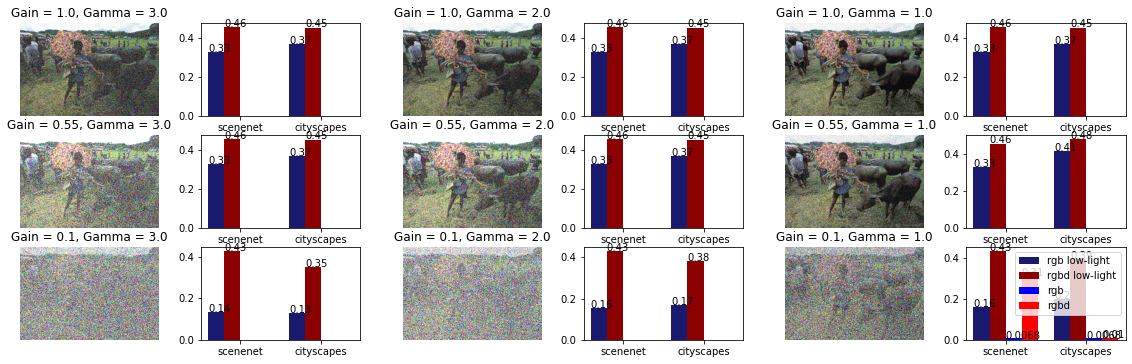

In [94]:
plt.figure(figsize=(20, 12))

index = 1
for i in gain:
    for j in gamma:
        sample['image'] = image.copy()
        
        cfg = get_cfg_defaults()
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        f = tr.Darken(cfg)
        processed_sample = f(sample)
        
        f = tr.UnDarken(cfg)
        processed_sample = f(processed_sample)
        
        plt.subplot(len(gain)*2, len(gamma)*2, index)
        plt.imshow(processed_sample['image'])
        plt.title("Gain = {}, Gamma = {}".format(i, j))
        plt.axis('off')
        index += 1
        
        labels = ['scenenet', 'cityscapes']
                
        y_pos = np.arange(2)
        width = 0.20
        
        ax1 = plt.subplot(len(gain)*2, len(gamma)*2, index)
        ax1.bar(y_pos - 2*width, [metric_dict['RGB']['low-light']['scenenet'][i][j], 
                                 metric_dict['RGB']['low-light']['cityscapes'][i][j]], 
                width=width, color='midnightblue', label="rgb low-light")
        ax1.bar(y_pos - width, [metric_dict['RGBD']['low-light']['scenenet'][i][j], 
                                metric_dict['RGBD']['low-light']['cityscapes'][i][j]], 
                width=width, color='darkred', label="rgbd low-light")
        ax1.bar(y_pos, [metric_dict['RGB']['normal']['scenenet'][i][j], 
                        metric_dict['RGB']['normal']['scenenet'][i][j]], 
                width=width, color='blue', label="rgb")
        ax1.bar(y_pos + width, [metric_dict['RGBD']['normal']['scenenet'][i][j], 
                                metric_dict['RGBD']['normal']['cityscapes'][i][j]],
                width=width, color='red', label="rgbd")
    
        ax1.set_xticks(y_pos - 0.1)
        ax1.set_xticklabels(labels)
        
        for p in ax1.patches:
            if p.get_height() > 0 :
                ax1.annotate("{:3.2}".format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
            
        index += 1
        
ax1.legend()